A.shape=(4096, 4096) b.shape=(4096, 128)
N=4096, R=128, getrf_gflop=45.805, getrs_gflop=2.147

numpy err  = 3.95575e-09
numpy time = 1137.1942 ms, 42.1666 GF/s


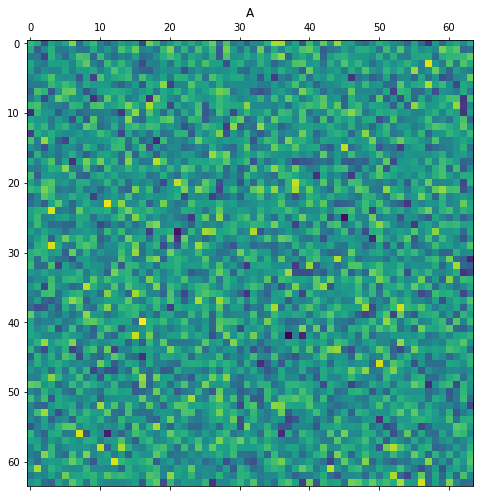

In [1]:
"""
Solve Ax = b using cuSolver (LU decomposition)
"""

# numpy/init part
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = [4, 8]
np.set_printoptions(formatter={'float': '{: .3f}'.format})

N       = 4096  # size
R       = 128   # nrhs
run_cpu = True  # may need to disable for large A

# estimate FLOP count
# https://cscproxy.mpi-magdeburg.mpg.de/mpcsc/lehre/2016_WS_SC/handouts/handout_LU_counting.pdf
getrf_gflop = 1e-9 * ((2/3)* N**3 - (1/2)* N**2) # approximately
getrs_gflop = 1e-9 * (R * (N**2 - N)) # more/less proporional to R
total_gflop = getrs_gflop + getrf_gflop

A = np.random.randn(N, N).astype(np.float64, order='F')
b = np.random.randn(N, R).astype(np.float64, order='F')

# just to confirm the dims
print(f'{A.shape=} {b.shape=}')
print(f'{N=}, {R=}, {getrf_gflop=:5.3f}, {getrs_gflop=:5.3f}')
print('')

# show the top left corner of A for debug
fig = plt.matshow(A[:64,:64])
plt.title('A')

if run_cpu:
    
    t0 = time()
    x = np.linalg.solve(A, b).astype(np.float64)
    t_numpy = (time() - t0)

    err = np.linalg.norm(np.dot(A, x) - b)
    print(f'numpy err  = {err:g}\n'
          f'numpy time = {1e3 * t_numpy:.4f} ms, {total_gflop/t_numpy:.4f} GF/s')
else:
    # just a placeholder if not calculating
    x = np.zeros((N, R)).astype(np.float64, order='F')
    t_numpy = np.inf
    err = np.inf

In [2]:
# GPU
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.driver as drv

import skcuda.cublas as cublas
import skcuda.cusolver as cusolver

def lu_cusolver(handle, A, b, repeat=1, debug=False):
        
    d_A = gpuarray.to_gpu(A)
    d_b = gpuarray.to_gpu(b)

    d_info = gpuarray.zeros(1, np.int32)
    d_ipiv = gpuarray.zeros((N, ), np.int32)

    worksize = cusolver.cusolverDnDgetrf_bufferSize(handle, N, N, d_A.ptr, 0)
    scratchpad = gpuarray.empty(worksize, np.float64)

    start_getrf = drv.Event()
    end_getrf   = drv.Event()

    # cusolverDnDgetrf(
    # handle, m, n, a, lda, workspace, devIpiv, devInfo)
    start_getrf.record()

    for i in range(repeat):
        cusolver.cusolverDnDgetrf(
            handle=handle,
            m=N,
            n=N,
            a=d_A.ptr,
            lda=N,
            workspace=scratchpad.ptr,
            devIpiv=d_ipiv.ptr,
            devInfo=d_info.ptr
        )

    end_getrf.record()
    end_getrf.synchronize()
    getrf_time = end_getrf.time_since(start_getrf) / (repeat * 1e3)

    if debug:
        # show the left top corner for debug
        fig = plt.matshow(d_A.get()[:64,:64])
        plt.title('LU')
    
    if d_info.get()[0] != 0:
        print(f'! err: {d_info}')

    start_getrs = drv.Event()
    end_getrs   = drv.Event()

    start_getrs.record()

    # cusolverDnDgetrs(
    # handle, trans, n, nrhs, a, lda, devIpiv, B, ldb, devInfo)

    for i in range(repeat):
        cusolver.cusolverDnDgetrs(
            handle=handle,
            trans=0,
            n=N,
            nrhs=R,
            a=d_A.ptr,
            lda=N,
            devIpiv=d_ipiv.ptr,
            B=d_b.ptr,
            ldb=N,
            devInfo=d_info.ptr
        )

    end_getrs.record()
    end_getrs.synchronize()
    getrs_time = end_getrs.time_since(start_getrs) / (repeat * 1e3)
    
    if d_info.get()[0] != 0:
        print(f'! err: {d_info}')
    
    x_cuda = d_b.get()

    return x_cuda, getrf_time, getrs_time 


pycuda.VERSION_TEXT='2021.1'
drv.get_version()=(11, 5, 0)
drv.get_driver_version()=11050

5 device(s) found.
Device #0: NVIDIA A100-SXM-80GB
  Arch: 8.0, Mem: 81251 MB, 2039 GBps
  108 SMs, 6912 cores, 40.0 MB L2, 1.41 GHz
     TF/s:      9.75 FP64     19.49 FP32     77.97 FP16
  TC TF/s:     19.49 FP64    155.93 FP32    311.87 FP16

Device #1: NVIDIA A100-SXM-80GB
  Arch: 8.0, Mem: 81251 MB, 2039 GBps
  108 SMs, 6912 cores, 40.0 MB L2, 1.41 GHz
     TF/s:      9.75 FP64     19.49 FP32     77.97 FP16
  TC TF/s:     19.49 FP64    155.93 FP32    311.87 FP16

Device #2: NVIDIA A100-SXM-80GB
  Arch: 8.0, Mem: 81251 MB, 2039 GBps
  108 SMs, 6912 cores, 40.0 MB L2, 1.41 GHz
     TF/s:      9.75 FP64     19.49 FP32     77.97 FP16
  TC TF/s:     19.49 FP64    155.93 FP32    311.87 FP16

Device #3: NVIDIA A100-SXM-80GB
  Arch: 8.0, Mem: 81251 MB, 2039 GBps
  108 SMs, 6912 cores, 40.0 MB L2, 1.41 GHz
     TF/s:      9.75 FP64     19.49 FP32     77.97 FP16
  TC TF/s:     19.49 FP64    155.93 FP3

Text(0.5, 1.0, 'solution cusolver')

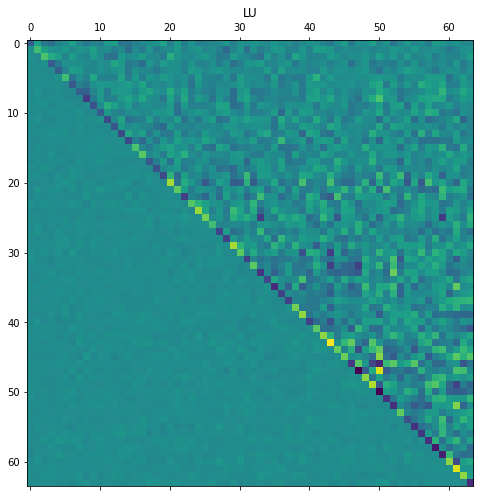

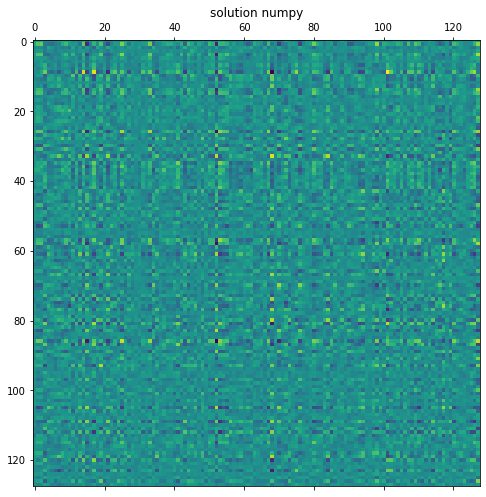

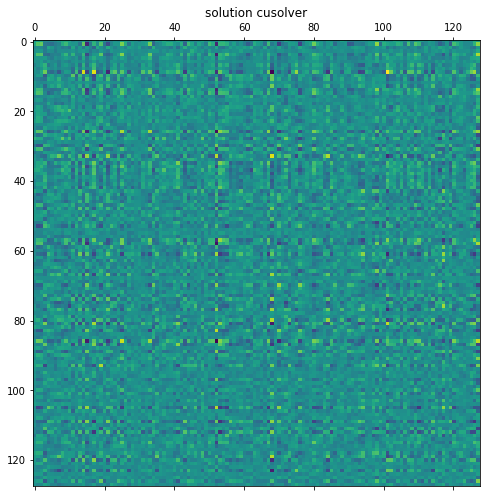

In [3]:
import util

print()
print(f'{pycuda.VERSION_TEXT=}')
print(f'{drv.get_version()=}')
print(f'{drv.get_driver_version()=}')
print()

util.query(drv)

# select device
dev_id = 1
ctx = drv.Device(dev_id).make_context()
dev = drv.Context.get_device()
free_bytes, total_bytes = drv.mem_get_info()
print(f'Using device {dev_id} ({dev.name()})')

handle = cusolver.cusolverDnCreate()

# LU using cuSolver
x_cuda, _, _ = lu_cusolver(handle, A, b, repeat=1, debug=True)

# rerun for benchmarking
_, getrf_time, getrs_time = lu_cusolver(handle, A, b, repeat=100, debug=False)

# check solution(s)
err_cusolver = np.linalg.norm(np.dot(A, x_cuda) - b)
status = cusolver.cusolverDnDestroy(handle)

print(f'cusolverDnDgetrf time = {getrf_time:.4f} ms, {getrf_gflop/getrf_time:.4f} GF/s\n'
      f'cusolverDnDgetrs time = {getrs_time:.4f} ms, {getrs_gflop/getrs_time:.4f} GF/s\n'
      f'cusolver err          = {err_cusolver:g}\n')

# show the top left corners for debug
plt.matshow(x[:128,:128].T)
plt.title('solution numpy')
plt.matshow(x_cuda[:128,:128].T)
plt.title('solution cusolver')

In [4]:
# sweep some different sizes
Ns = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
Rs = [1, 4, 16, 64, 256, 512, 1024, 4096]

getrf_perf = np.zeros((len(Ns), 1))
getrs_perf = np.zeros((len(Rs), len(Ns)))

repeat = 10

handle = cusolver.cusolverDnCreate()

# disable checking err if slow
check_err = True

for i in range(len(Ns)):
    for j in range(len(Rs)):
        
        N = Ns[i]
        R = Rs[j]
        
        getrf_gflop = 1e-9 * ((2/3)* N**3 - (1/2)* N**2) # approximately
        getrs_gflop = 1e-9 * (R * (N**2 - N)) # more/less proporional to R
        total_gflop = getrs_gflop + getrf_gflop
        
        A = np.random.randn(N, N).astype(np.float64, order='F')
        b = np.random.randn(N, R).astype(np.float64, order='F')

        if check_err:
            x_cuda, _, _ = lu_cusolver(handle, A, b, repeat=1, debug=False)
            err_cusolver = np.linalg.norm(np.dot(A, x_cuda) - b)
        else:
            err_cusolver = 0
            
        _, getrf_time, getrs_time = lu_cusolver(handle, A, b, repeat=repeat, debug=False)
        
        getrf_perf[i][0] = getrf_gflop/getrf_time
        getrs_perf[j][i] = getrs_gflop/getrs_time

        print(f'{N=:5d}, {R=:5d}, {getrf_gflop=:7.2f}, {getrs_gflop=:7.2f}, '
              f'LU time = {1e3 * getrf_time:7.2f} ms, {getrf_gflop/getrf_time:7.2f} GF/s, '
              f'S time = {1e3 * getrs_time:7.2f} ms, {getrs_gflop/getrs_time:7.2f} GF/s, '
              f'err = {err_cusolver:14g}')
        
status = cusolver.cusolverDnDestroy(handle)

N=   32, R=    1, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.03 ms,    0.04 GF/s, err =     3.3115e-14
N=   32, R=    4, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.03 ms,    0.14 GF/s, err =    1.73784e-14
N=   32, R=   16, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.05 ms,    0.34 GF/s, err =    5.98626e-14
N=   32, R=   64, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.03 ms,    2.42 GF/s, err =    1.74541e-13
N=   32, R=  256, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.03 ms,    9.44 GF/s, err =    2.00869e-13
N=   32, R=  512, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.24 GF/s, S time =    0.03 ms,   18.58 GF/s, err =    4.17994e-13
N=   32, R= 1024, getrf_gflop=   0.00, getrs_gflop=   0.00, LU time =    0.09 ms,    0.2

Text(0, 0.5, 'GF/s')

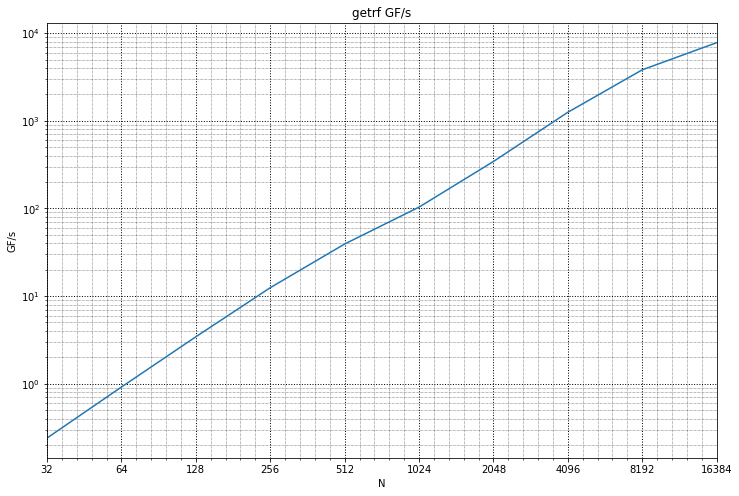

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
im = ax.plot(getrf_perf)
ax.set_xticks(np.arange(len(Ns)))
ax.set_xticklabels(Ns)
plt.title('getrf GF/s')
plt.xlim([0, len(Ns)-1])
ax.set_yscale('log')
ax.grid(which='major', color='#000000', linestyle=':', linewidth=1)
ax.grid(which='minor', color='#000000', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_xlabel('N')
ax.set_ylabel('GF/s')

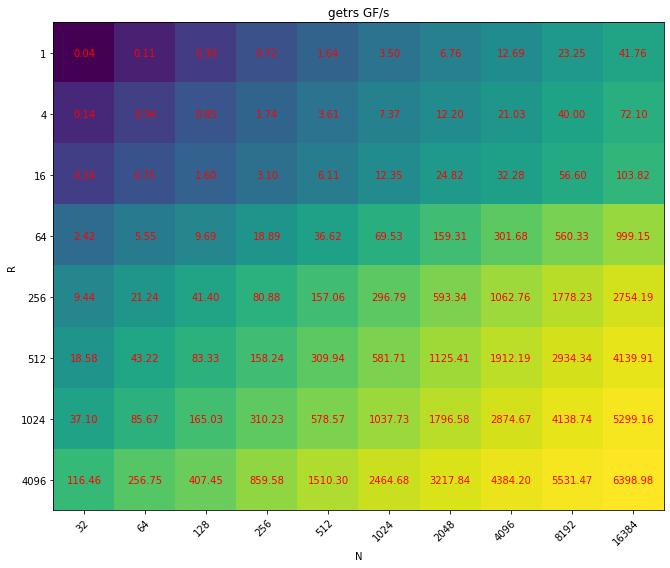

In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
im = ax.imshow(getrs_perf, cmap='viridis', norm=matplotlib.colors.LogNorm())
ax.set_xticks(np.arange(len(Ns)))
ax.set_yticks(np.arange(len(Rs)))
ax.set_xticklabels(Ns)
ax.set_yticklabels(Rs)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(Ns)):
    for j in range(len(Rs)):
        text = ax.text(i, j, f'{getrs_perf[j, i]:.2f}',
                       ha="center", va="center", color="r")
ax.set_title("getrs GF/s")
plt.xlabel("N")
plt.ylabel("R")
fig.tight_layout()